# A novel Digital Beam-Forming Concept for spaceborne Reflector SAR Systems

Author : Rishikesh Kakade - rkakade@protonmail.com

This notebook aims to reproduce the results of this paper published in the Proceedings of the 6th European Radar Conference: 

[A novel Digital Beam-Forming Concept for spaceborne Reflector SAR Systems](https://ieeexplore.ieee.org/abstract/document/5306998)

The model used to generate data for demonstrating the results of the paper was taken from this book by Bu-Chin Wang:

[Digital Signal Processing Techniques and Applications in Radar Signal Image Processing](https://www.wiley.com/en-us/Digital+Signal+Processing+Techniques+and+Applications+in+Radar+Image+Processing-p-9780470377826)

## Problem Formulation

At the time this paper was written, most Synthetic Aperture Radars (SAR) used planar phased antenna arrays, like the one in Figure 1.1, to direct the gain pattern of the antenna toward targets on the ground.

<figure>
  <img src="images/planar.jpg" width=200 height=200 />
  <figcaption>Figure 1.1 - Ballistic Missile Early Warning System in Alaska using a planar antenna array. 
       <a href="https://commons.wikimedia.org/wiki/File:PAVE_PAWS_Radar_Clear_AFS_Alaska.jpg">Image source.</a> 
  </figcaption>
</figure> 

The downside of this architecture was that the swath area illuminated on the ground by two adjacent antenna elements overlapped significantly. To overcome this, the paper suggests the use of a parabolic reflector dish, that places the antenna array feed at the focus of the dish.  

<figure>
  <img src="images/parabolic.png" width=200 height=200 />
  <figcaption>Figure 1.2 - Parabolic reflector with offset antenna feed.
    <a href="https://www.semanticscholar.org/paper/Design-of-an-Array-Feed-Offset-Parabolic-Reflector-Michishita-Shinohara/8cc1a6cfbc9618c2e06f2778b76e438fbc89ce7f">Image source.</a> 
    </figcaption>
</figure> 


The result is a lighter system, requiring a smaller feed array with lower power demands, to produce an equivalently sized antenna aperture. The convenient radiation characteristics make it possible to direct EM energy in a very sharp beam, which minimizes losses at the swath borders. The new antenna architecture necessitates a custom beamforming algorithm be devised.  

## Proposed Solution

<figure>
  <img src="images/algorithmic_flow.png" width=200 height=200 />
  <figcaption>Figure 2.1 - Algorithmic flow.</figcaption>
</figure> 

The workflow breaks down into two main stages: data synthesis then processing. 

In the synthesis stage, the goal is to generate the raw data that a SAR with a linear antenna array and parabolic reflector dish would receive along all of its signal channels. First, a symmetric chirp signal is generated to model the first pulse the radar transmits to begin imaging the ground. The signal is normalized for the impact the structure of the parabolic architecture has on it. The gain pattern of this structure is not isotropic (meaning spherical) and so it is necessary to adjust the amplitude of the signal depending on how the signal is physically projected on the ground. Then, a simple environment of a point reflector on perfectly absorbant ground is modelled. As unrealistic as this environment sounds, it's actually similar to how something like a ship in the middle of the ocean would show up in a SAR image. The steel of the vessel scatters radio waves whereas the surrounding water absorbs it. 

 <figure>
  <img src="images/ocean_base.jpg" width=500 height=500 />
  <figcaption>Figure 2.1 - SAR imagery of a North Korean naval base. The dark (absorbant) material is water. Distortions are partly due to thermal channel noise. 
    <a href="https://www.38north.org/2020/01/sinpo010320/">Image source.</a> 
    </figcaption>
</figure> 

Assumptions in this stage:
1. The radar is moving at a speed much lower than the speed of light. This allows the model to ignore relativistic effects. 
2. Ignore the inclination angle. The distance from the radar to the target is on the same order as the distance from the point directly below the radar to the target. This allows the model to ignore the curvature of the planet as well. 
3. The ground surrounding the target is perfectly absorbant. All components of the signal except for the target are considered noise. 
4. The target is a perfect reflector, and is stationary. No motion compensation required. 
5. The real and imaginary part of the gain pattern are equal. Matlab was only able to export the magnitude of the radiation pattern. I chose to approximate the real and imaginary parts at every part along the azimuth pattern as differing from the magnitude by a factor of $\frac{1}{\sqrt(2)}$. 

The implications of these assumptions are further discussed in the conclusion.

In the processing stage, the first method described in the paper is implemented. It begins by range compressing then uses conjugate field matching (CFM) to select channels that are significant and create a cohesive image.  

Assumptions in this stage:
1. The 'individual complex channel pattern, g' described in the paper refers to the non-isotropic gain pattern of the antenna architecture described in the paper. 

## Data Sources

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import math
from collections import defaultdict
import scipy.io as scio
import sys

The mathematical description of SA radar operation was taken from Bu-Chin Wang's textbook, [Digital Signal Processing Techniques and Applications in Radar Signal Image Processing](https://www.wiley.com/en-us/Digital+Signal+Processing+Techniques+and+Applications+in+Radar+Image+Processing-p-9780470377826). Page numbers and equations are cited within the comments.

The basis for all SAR operation is the linear frequency modulated (LFM) pulse. Wang models a symmetric pulse from an isotropic radiator (a radiator whose 3 dB contour is the unit sphere) in Equation 5.11a, 
$$
p(t) = A_{0} Rect\left( \frac{1-0.5T_{p} }{T_{p}}\right)\exp[2 j \pi f_{c}(t-0.5T_{p})+j\pi\alpha (t-0.5T_{p})^{2}]
$$

Where, $A_{0}$ is the amplitude of the chirp, $T_{p}$ is the duration of the pulse, $T$ is the signal period, $f_{c}$ is the carrier frequency and $\alpha$ is the frequency ramp constant.

In [2]:
def gen_symmetric_LFM(A_0, T_p, T, f_c, alpha, f_s):
    t = np.linspace(0, T, int(math.ceil(T*f_s)), endpoint=False) # time basis
    rect = np.where(abs((t-T_p/2)/T_p)<=0.5,1,0) # rect function to clip the 'infinite' function.
    p = A_0*rect*np.exp(1j*2*np.pi*f_c*(t-T_p/2) + 1j*np.pi*alpha*(t-T_p/2)**2) # symmetric LFM model, equation 5.11a from page 125 of Wang
    return p

In [3]:
##########################################################
# These coefficients were taken from page 233 and 234 of 
# Wang. A screenshot is in images/Wang_Page_233_234.png
#
# I had to tweak some parameters to make the plot look like
# the one presented on page 128 and also be representative 
# of the characteristics described in Table 1 of the paper.
# 
# f_c was 10e9 in the textbook. I changed this to 5.4e9,
# which is a scaling factor of 0.54. 
# alpha was 4e12 in the textbook, so 0.54*4 = 1.16.
##########################################################

#######################################################
# Linear chirp parameters
#######################################################
# Amplitude of Tx signal [m]
A_0 = 1.0
# Range FM rate/Frequency chirp rate [Hz/s]. f = f_c +alpha*t
alpha = 2.16e12 # this was 4e12 in the textbook
# Symmetric LFM pulse time duration [s]. This is the width of the rect func. 
T_p = 6.03333333333e-6
# Range sampling frequency [Hz]
f_s = 30e6
# Total period of pulse train [s]
T = T_p
# Radar beam carrier frequency [Hz]. C-Band from 4-8 Ghz
f_c = 5.4e9 

In [4]:
def LFM_plot(p):
    fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
    a = axs.flat

    # plot chirp in time domain
    x = range(0, len(p))
    y1 = p.real
    y2 = p.imag

    a[0].plot(x, y1)
    a[0].set_title('LFM real part in time-domain')
    a[0].set_xlabel('Time [s]')
    a[0].set_ylabel('Amplitude [Abs]')

    a[1].plot(x, y2)
    a[1].set_title('LFM imaginary part in time-domain')
    a[1].set_xlabel('Time [s]')
    a[1].set_ylabel('Amplitude [Abs]')

    # plot magnitude spectrum
    sig = np.fft.fftshift(np.fft.fft(p))
    n = len(sig) 
    k = np.arange(-n/2, n/2)
    T = n/f_s
    x = k/T
    y1 = abs(sig)
    
    a[2].plot(x, abs(y1))
    a[2].set_title('LFM spectrum magnitude response')
    a[2].set_xlabel('Frequency [Hz]')
    a[2].set_ylabel('Magnitude [Abs]')
    
    # plot phase spectrum
    y2 = np.angle(sig, deg=True)

    a[3].plot(x, y2)
    a[3].set_title('LFM wrapped phase response')
    a[3].set_xlabel('Frequency [Hz]')
    a[3].set_ylabel('Angle [Degrees]')

In [5]:
p = gen_symmetric_LFM(A_0, T_p, T, f_c, alpha, f_s)

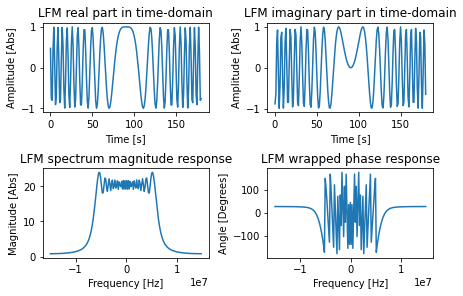

In [6]:
LFM_plot(p)

Figure 3.1

This chirp signal is the initial pulse transmitted by the SAR toward the ground. The target is imaged by processing the signal that echoes back from this pulse. A similar result is on page 128 of Wang.

---

This notebook will generate data as would be seen by a stripmap SAR. The radar moves in a straight line and images objects along a parallel line on the ground.

<figure>
  <img src="images/stripmap.png" width=200 height=200 />
  <figcaption>Figure 3.2 - Schematic of stripmap SAR configuration. Source: Page 156 of Wang</figcaption>
</figure> 

Let's discuss some of the geometry,

<figure>
  <img src="images/geometry_strip.png" width=200 height=200 />
  <figcaption>Figure 3.3 - Geometry of stripmap imaging radar. Source: Page 157 Wang</figcaption>
</figure> 

The radar moves with velocity $\bar{V}$ at height $H$, and has a swath range $R_{0}$. Each element in the LxW array illuminates a fraction of the footprint projected on the ground, each element illuminating an area that overlaps with the area illuminated by an adjacent element. For a rectangular array, the projected footprint is an ellipse with a major axis of length $R_{0}\frac{\lambda}{L}$ and a minor axis with length $R_{0}\frac{\lambda}{W}$. The swath is constructed by the union of all footprints created by successive radar pulses as the radar moves. The radar transmits pulses at a frequency called the pulse repetition frequency (PRF). The target being imaged lies along the swath median. The time interval for which the radar will illuminate the target is $R_{0}\frac{\lambda}{L}/|V|$. 

---

The paper suggests the radar antenna should be a linear phased array placed at the focus of a parabolic reflector dish. I used the antenna toolbox in Matlab to realize the system. Since the initial chirp was for an isotropic radiator, we have to normalize for our system architecture.

Wang derives the reasoning for this step on page 169. 

I used the Antenna Toolbox in Matlab to design this structure with parameters as close as possible to those described in the paper. Take a look at antenna_system.mlx for a better idea. 

<figure>
  <img src="images/pattern.png" width=500 height=500 />
  <figcaption>Figure 3.4 - Simulation of gain pattern and structure of array with reflector.</figcaption>
</figure> 

<figure>
  <img src="images/elevation.png" width=300 height=300 />
  <figcaption>Figure 3.5 - 3 dB elevation contour.</figcaption>
</figure> 

<figure>
  <img src="images/azimuth.png" width=300 height=300 />
  <figcaption>Figure 3.6 - 3 dB azimuth contour.</figcaption>
</figure> 

Text(0, 0.5, 'Amplitude')

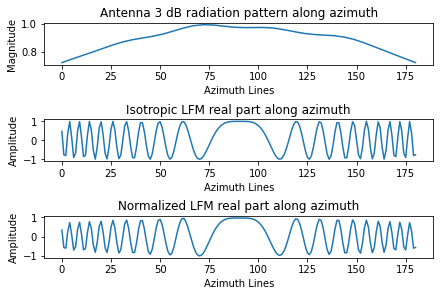

In [7]:
# load the aximuth radiation pattern contour
x_abs = scio.loadmat('radiation_pattern.mat') 
# Preprocess the data
x_abs = np.array(x_abs['x_abs']).flatten()
angles = np.linspace(0, 360, 361)
x_abs = (x_abs - np.min(x_abs)) / (np.max(x_abs) - np.min(x_abs))

# Extract part that is more than 3 dB
rect = np.where(x_abs >= 1/math.sqrt(2), 1, 0).flatten()
x_abs = x_abs*rect
angles = angles*rect

x_abs = x_abs[30:150]
angles = angles[30:150]

x_abs = x_abs[x_abs != 0.0]
angles = angles[angles!=0.0]

az_lines = np.linspace(angles[0], angles[-1], math.ceil(f_s*T_p))
gain = np.interp(az_lines, angles, x_abs) # interpolate to the gain array have the same number of data points as the LFM pulse

fig, axs = plt.subplots(nrows=3, ncols=1, constrained_layout=True)

# plot gain pattern
axs = axs.flat
axs[0].plot(np.linspace(0, 180, 181), gain)
axs[0].set_title('Antenna 3 dB radiation pattern along azimuth')
axs[0].set_xlabel('Azimuth Lines')
axs[0].set_ylabel('Magnitude')

# plot baseline LFM pulse
x = range(0, len(p))
y1 = p.real

axs[1].plot(x, y1)
axs[1].set_title('Isotropic LFM real part along azimuth')
axs[1].set_xlabel('Azimuth Lines')
axs[1].set_ylabel('Amplitude')

# plot normalized LFM pulse
y2 = p.real*gain
axs[2].plot(x, y2)
axs[2].set_title('Normalized LFM real part along azimuth')
axs[2].set_xlabel('Azimuth Lines')
axs[2].set_ylabel('Amplitude')

Figure 3.7

The difference is hard to notice but, look carefully near the signal edges. The high frequency components are supressed. This normalized chirp signal is what will be projected on to the ground. This image recreates Figure 6.14 in Wang. 

---

Now develop a model for how this signal echoes back as the received signal. 

To develop a conceptual understanding, consider the following target function of a single impulse. 

$$
f(x_{0}, y_{0}) = \sigma_{0}\delta(x-x_{0})
$$

It is some range away from the satellite on the ground, at coordinate ($x_{0}$, $y_{0}$, 0), and has a reflection coefficient $\sigma_{0}=1$ for simplicity. 


It's important to note that SAR imaging doesn't work like human vision; meaning the analog of the color spectrum is grayscale. The closest thing in real life that this models is a point reflector in the middle of the ocean as the surrounding water absorbs any radio signal directed toward it. 

In [8]:
##########################################################
# These coefficients were taken from page 233 and 234 of 
# Wang. A screenshot is in images/Wang_Page_233_234.png
#
# I had to tweak some parameters to make the plot look like
# the one presented on page 128 and also be representative 
# of the characteristics described in Table 1 of the paper.
# 
# f_c was 10e9 in the textbook. I changed this to 5.4e9,
# which is a scaling factor of 0.54. 
# alpha was 4e12 in the textbook, so 0.54*4 = 1.16.
# R_0 was 7500m, so 7500*0.54 = 4050
##########################################################

##########################################################
# Signal parameters
##########################################################
# Carrier phase velocity, light speed in vaccum/air [m/s]
v_ph = 299792458
# Carrier pulse repetition frequency [Hz]
f_PRF = 500
# Carrier wavelength [m]
lambda_c = v_ph/f_c
# Carrier frequency [Hz]
f_c = 5.4e9
# Range FM rate/Frequency chirp rate [Hz/s]. f = f_c +alpha*t
alpha = 2.16e12
# Sampling frequency [Hz]
f_s = 30e6

##########################################################
# Radar physical parameters
##########################################################
# Radar moving speed [km/s]
V = 200
# Antenna length [m]
L = 1

##########################################################
# Target parameters
##########################################################
# Position of target along flight path [m]
y_1 = 0 
# Range at closest approach to the target [m]
R_0 = 4050

##########################################################
# Echo parameters
##########################################################
# Number of time samples within LFM pulse 
N_r = int(math.ceil(f_s*T_p))
# Number of time samples
N_tot = N_r

# Radar 3-dB azimuthal beamwidth (radians)
theta_H = lambda_c/L

# Azimuth sample spacing [m]
A_s = V/f_PRF
# Synthetic aperture length [m]
L_s = R_0*theta_H

# Number of azimuth samples 
N_az = math.ceil(L_s/A_s)

In [9]:
def baseband(f_c, tau_u_i, alpha, T_p, t_n): 
    return np.exp(-1j*2*np.pi*f_c*(tau_u_i)+ 1j*np.pi*alpha*(t_n-T_p/2-tau_u_i)**2) # equation 8.4c on page 229 of Wang

In [10]:
def tau(u_i, y, R_0): 
    return 2 * math.sqrt((u_i-y)**2 + R_0**2)/v_ph # equation 8.5b on page 234 of Wang

In [11]:
def baseband_construction(): # "Record" the Rx signal from the ground along N_az azimuth lines. 
    r_b = np.zeros((N_az, N_tot)).astype(np.complex64) # the textbook calls this the 'received baseband'
    u_i = np.arange(0, N_az, A_s) # The radar recieves the signal at every u_i spaced out by A_s
    t_n = np.linspace(0, T, int(math.ceil(T*f_s)), endpoint=False) # time basis

    for i in range(N_az): # implement equation 8.4c on page 229 of Wang
        tau_u_i = tau(u_i[i], y_1, R_0) # equation 8.5b on page 234 of Wang
        rect = np.where(abs((t_n-T_p/2)/T_p)<=0.5,1,0) # rect function for making LFM pulse
        r_b[i] = baseband(f_c, tau_u_i, alpha, T_p, t_n)*abs(rect)**2 #*gain # compensate for the antenna gain pattern
        
    return r_b 

In [12]:
r_b = baseband_construction()

And with this, a raw dataset is has been generated!

Figure 4 from the paper is recreated by simply plotting the time and frequency domains of one azimuth line. This is the signal that would be recieved by one of the channels on the antenna array. 

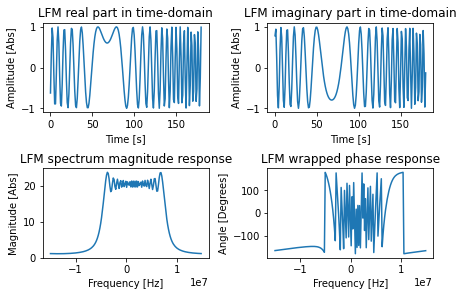

In [13]:
LFM_plot(r_b[0])

The last thing to do is add a little gaussian noise (AWGN) to each azimuth sample and also factor in the effect of the antenna architecture. This is Equation 1 in the paper.  Part of the goal in the processing section is to reduce the effect this noise has on the final image. 

In [14]:
for i in range(N_az): # use a for loop because the noise on each channel should be uncorrelated
    noise = np.random.normal(0, 0.5, 181) + 1j*np.random.normal(0, 0.5, 181) 
    channel_effect = gain/np.sqrt(2) + 1j*gain/np.sqrt(2) 
    r_b[i] = r_b[i]*channel_effect + noise  # Equation 1 from the paper

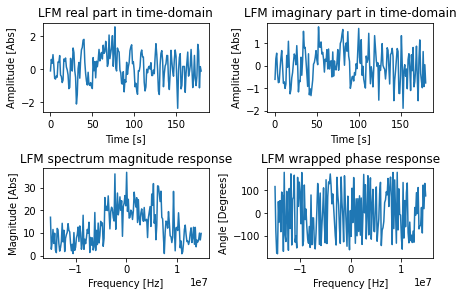

In [15]:
LFM_plot(r_b[0]) 

## Solution

The paper presents two novel methods for digital beamforming with this architecture along with two conventional methods to demonstrate improvement. 
* Method 1
    1. Range compress the individual channel raw data streams
    2. Assign weights to data samples using conjugate field matching (CFM). As an aside, the CFM method is also known as phase conjugate weighting, or spatial matched filtering.
    3. Combine selected data samples using delay and sum 
* Method 2
    1. Process blocks of 256 data samples from selected channels
    2. Frequency adaptive filtering to isolate signal components originating from different point scatterers
    3. Combine selected data samples using delay and sum
* Method 3
    1. Unity weighting beamformer
    2. Combine selected data samples using delay and sum
* Method 4 
    1. Assign weights to data samples using CFM. 
    2. Combine selected data samples using delay and sum
    

---

#### Method 1

Range compression is really quite simple. The goal is to compare the transmitted chirp signal with the recieved signal that interacted with the terrain on the ground. To use more precise language, we can say 'convolve' instead of 'compare'. 

To improve the quality of the signal even more, we can choose to convolve it with the complex conjugate of the transmit signal. To understand why this makes sense, recall that if A is a matrix:

$$A*A^{*} = |A|^{2}$$

In an ideal world, the ground is a perfect reflector, and the signal that is transmitted to the ground is reflected and recieved back in its original form, along with some thermal noise. By multiplying the recieved signal with its conjugate, we 'amplify' the signal over the noise component. 

A good explanation for range compression is in [these slides by Jeremy Nicoll](https://rudigens.github.io/geos639/sar_processing.pdf)
at the University of Alaska.

In [16]:
def range_compression(rx, tx): # implement slide 20 of Rudi Gens' slide deck about range compression
    freq_rx = np.fft.fftshift(np.fft.fft(rx)) # bring recieved signal to freqency domain    
    freq_tx = np.fft.fftshift(np.fft.fft(np.conjugate(tx) )) # bring transmitted signal to frequency domain
    freq_signal = freq_rx * freq_tx # multiplication in frequency is convolusion in time domain
    signal = np.fft.ifft(np.fft.fftshift(freq_signal)) # bring back to time domain
    
    return signal

In [17]:
local_LFM = gen_symmetric_LFM(A_0, T_p, T, f_c, alpha, f_s) # re-generate the pulse that was first transmitted
r_b = range_compression(r_b, local_LFM)

Let's take a look at one of the signals.

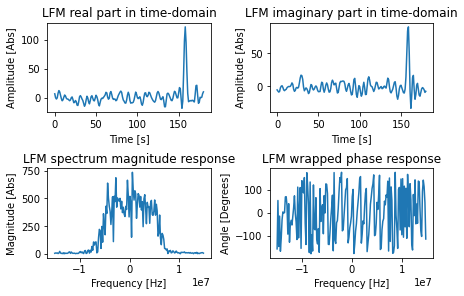

In [18]:
LFM_plot(r_b[0])

It looks like the amplitude peaks around 150s. This is the point target! 

The paper suggests a second step that applies weights to certain channels. The intent is to reduce gain loss. 

Equation 4 from the paper: 

$$w[k] = \frac{1}{g^{T}(k)  g^{*}(k)} g^{*}(k)$$

where $g(k)$ is the 'complex indvidual channel pattern'. Put simply, this is the way the signal interacts with the antenna on transmit and recieve.  Earlier, the Antenna Toolbox in Matlab was used to model the non-isotropic gain pattern of the architecture the paper proposes. The complex gain pattern was multiplied with the signal and is represented by the vector g in this equation.  

In [19]:
def channel_weight(gain): # implement Equation 4 from the paper
    g = gain/np.sqrt(2) + 1j*gain/np.sqrt(2) 
    return np.conjugate(g)/(np.transpose(g) @ np.conjugate(g)) 

In [20]:
r_b = r_b * channel_weight(gain)

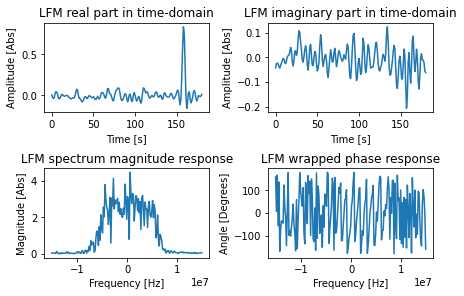

In [21]:
LFM_plot(r_b[0])

The last step is to combine all the channels to create a cohesive image.

In [22]:
sig = r_b[0] 
for i in range(N_az): # This just sums all channels together. 
                      # The signals seem to be mostly in phase and additional effort in implementing delay 
                      # compensation would yield marginal improvments to the final product.
    sig += r_b[i]

This is a *representation* of what the image of the ground would look like. The *tiny* speck of white on the right side is the point reflector on the ground. 

In [23]:
surrounding = np.random.normal(0, 1, size=(int(len(sig.real)/2), len(sig.real)))
image = np.vstack([surrounding, sig.real])
image = np.vstack([image, surrounding])

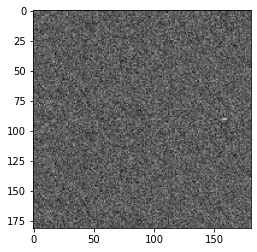

In [24]:
plt.imshow(image, cmap="gray") 
plt.show() 

All this work for one pixel...

## Visualization of Results

Plots are included throughout the notebook. This section will reiterate key portions.

---

### Symmetric LFM pulse transmitted by radar

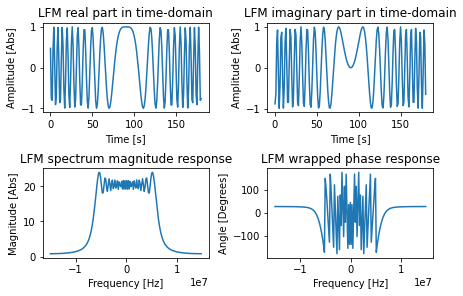

In [25]:
LFM_plot(p)

---

### LFM normalized for antenna gain pattern

Text(0, 0.5, 'Amplitude')

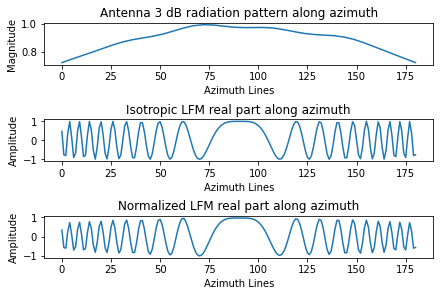

In [26]:
# load the aximuth radiation pattern contour
x_abs = scio.loadmat('radiation_pattern.mat') 
# Preprocess the data
x_abs = np.array(x_abs['x_abs']).flatten()
angles = np.linspace(0, 360, 361)
x_abs = (x_abs - np.min(x_abs)) / (np.max(x_abs) - np.min(x_abs))

# Extract part that is more than 3 dB
rect = np.where(x_abs >= 1/math.sqrt(2), 1, 0).flatten()
x_abs = x_abs*rect
angles = angles*rect

x_abs = x_abs[30:150]
angles = angles[30:150]

x_abs = x_abs[x_abs != 0.0]
angles = angles[angles!=0.0]

az_lines = np.linspace(angles[0], angles[-1], math.ceil(f_s*T_p))
gain = np.interp(az_lines, angles, x_abs) # interpolate to the gain array have the same number of data points as the LFM pulse

fig, axs = plt.subplots(nrows=3, ncols=1, constrained_layout=True)

# plot gain pattern
axs = axs.flat
axs[0].plot(np.linspace(0, 180, 181), gain)
axs[0].set_title('Antenna 3 dB radiation pattern along azimuth')
axs[0].set_xlabel('Azimuth Lines')
axs[0].set_ylabel('Magnitude')

# plot baseline LFM pulse
x = range(0, len(p))
y1 = p.real

axs[1].plot(x, y1)
axs[1].set_title('Isotropic LFM real part along azimuth')
axs[1].set_xlabel('Azimuth Lines')
axs[1].set_ylabel('Amplitude')

# plot normalized LFM pulse
y2 = p.real*gain
axs[2].plot(x, y2)
axs[2].set_title('Normalized LFM real part along azimuth')
axs[2].set_xlabel('Azimuth Lines')
axs[2].set_ylabel('Amplitude')

---

### Received data from point target simulation with noise and channel effects(single selected channel)

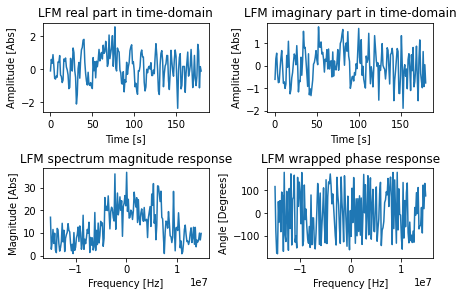

In [15]:
LFM_plot(r_b[0]) 

---

### Processed data sample using Method 1

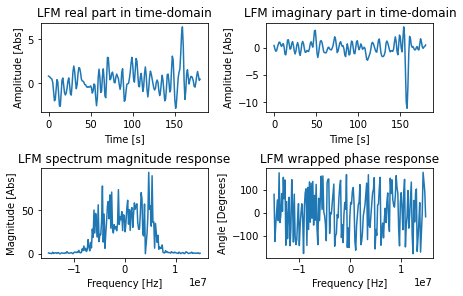

In [28]:
LFM_plot(r_b[0])

---

### Greyscale pixel image made using Method 1

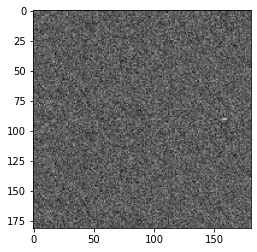

In [29]:
plt.imshow(image, cmap="gray") 
plt.show() 

---

## Analysis and Conclusion

All in all, the method described in the paper yields a coherent result. I was able to reconstruct the image of a point scatterer from additive noise and a non-uniform channel pattern. 

There was one part of the paper I was not able to implement however because of gaps in my own knowledge about radar imaging. The second method uses frequency adaptive filtering and I had trouble finding explanations at my level about how it is used in this context. I tried looking for more papers about it but ended up getting more confused. Since I wasn't able to implement method 2, I also wasn't able to reproduce Figures 5 or 6 from the paper. 

In relation to the method I was able to implement, I'll conclude that it is valid. 

However, I think it is important to highlight assumptions I made in coming to this conclusion and the influence they have on the result.  

First, the model makes the approximation that the SAR is moving at a speed much lower than the speed of light. In reality, satellites in orbit around Earth are moving at velocities in excess of 11 000 000 m/s, or 3.6% the speed of light. I believe that it is necessary to account for relativistic effects in this scenario. To my understanding, range compression mainly compensates for the non-relativistic Doppler effect. I believe this processing step to be potentially insufficient in this regard. 

Another approximation this model makes is that the radar is at an elevation that is on the same order as the distance from the nadir to the target (range). The lowest stable orbit any satellite can maintain around Earth is at the inner Van-Allen belt at 5 000 km. The radius of the Earth is about 6 000 km. Clearly, the curvature of the planet starts to matter here. I believe that a different model needs to be developed for this purpose. 

The only drawback to this method I can think of is the high computational needs considering the fact that a filter of order length(r_[i]) is needed to perform range compression. It's possible that the program would crash if a large enough data sample were processed. 

## References

[1] S. Huber, M. Younis, A. Patyuchenko, and G. Krieger, “A novel digital beam-forming concept for spaceborne reflector SAR systems,” in *Proceedings of the 6th European Radar Conference*, Rome, Italy, 2009, pp. 238–241.

[2] B. Wang, Digital Signal Processing Techniques and Applications in Radar Image Processing. New Jersey: John Wiley & Sons, 2008. 

[3] J. Nicoll, SAR Processing, Alaska: University of Alaska, Fairbanks, 2006, pp. 20.